# Unsupervised Learning

## Davis SML: Lecture 10 Part 3

## Prof. James Sharpnack

In [80]:
from lxml import html, etree
import numpy as np
from sklearn import cluster, feature_extraction, metrics, preprocessing, decomposition
import collections
import nltk
import pandas as pd
import plotnine as p9
# nltk.download()
# Download Corpora -> stopwords, Models -> punkt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

### TFIDF vectorization

- document vectorization counts the proportion of words in document
- $X_{i,j}$ is the "proportion" of word j in document i
- tfidf indicates term-frequency (proportion of words in document i which is word j), and inverse document frequency (log of inverse frequency of documents containing word j)

In [4]:
reu = html.parse("reuters/reut2-000.sgm") #You will have to do this for all sgm files here

In [47]:
def parse_reu(reu):
    """Parses the etree object and returns a list of dictionary of reuters attr
    Output: {'topics': the topic of the article, 'places': where it is located, 
        'split': training/test split, 'body':the text of the article as a set of words with stopwords removed}
    """
    root= reu.getroot()
    articles = root.body.getchildren()
    stop_words = set(stopwords.words('english'))
    reu_pl = []
    for a in articles:
        reu_parse = {}
        if a.attrib['topics'] != 'YES':
            next
        topics = a.find('topics').findall('d')
        if topics:
            reu_parse['topics'] = [t.text for t in topics]
        else:
            reu_parse['topics'] = []
        places = a.find('places').findall('d')
        if places:
            reu_parse['places'] = [t.text for t in places]
        reu_parse['split'] = a.attrib['lewissplit']
        rtxt = a.find('text')
        word_tokens = word_tokenize(rtxt.text_content())
        filtered_sentence = " ".join([w.lower() for w in word_tokens if not w in stop_words])
        reu_parse['body'] = filtered_sentence
        reu_pl.append(reu_parse)
    return reu_pl

In [48]:
reu_pl = parse_reu(reu)

In [49]:
print(reu_pl[0]['topics'])
reu_pl[0]['body']

['cocoa']


'bahia cocoa review salvador , feb 26 - showers continued throughout week bahia cocoa zone , alleviating drought since early january improving prospects coming temporao , although normal humidity levels restored , comissaria smith said weekly review . the dry period means temporao late year . arrivals week ended february 22 155,221 bags 60 kilos making cumulative total season 5.93 mln 5.81 stage last year . again seems cocoa delivered earlier consignment included arrivals figures . comissaria smith said still doubt much old crop cocoa still available harvesting practically come end . with total bahia crop estimates around 6.4 mln bags sales standing almost 6.2 mln hundred thousand bags still hands farmers , middlemen , exporters processors . there doubts much cocoa would fit export shippers experiencing dificulties obtaining +bahia superior+ certificates . in view lower quality recent weeks farmers sold good part cocoa held consignment . comissaria smith said spot bean prices rose 340 

In [88]:
vec = feature_extraction.text.TfidfVectorizer()
X = vec.fit_transform(doc['body'] for doc in reu_pl)
X.shape

(1000, 10749)

### Document clustering

- rows are documents, columns are words
- clustering with sklearn KMeans
- selected 10 clusters arbitrarily

In [82]:
doc_clust = cluster.KMeans(n_clusters=10)
doc_clust.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [84]:
doc_clust.cluster_centers_.shape

(10, 10749)

In [17]:
vocab_lookup = {b:a for a,b in vec.vocabulary_.items()}

In [29]:
ccargsort = doc_clust.cluster_centers_.argsort(axis=1)

In [31]:
center_vocab = [[vocab_lookup[row[-i]] for i in range(1,21)] for row in ccargsort]

In [35]:
print("\n\n".join([" ".join(voc) for voc in center_vocab]))

shr vs net qtr revs cts 4th 31 mln note profit jan loss year 16 reuter dlrs march shrs mths

organization quotas quota coffee meeting delegates talks agreement ico prices council export international london producers world accord said last opec

issue bond priced lead manager payment 100 issues issuing coupon the date pct eurobond mln co due franc said bank

000 shr net vs qtr cts revs 4th note year mln loss inc dlrs oper 12 1986 mths reuter avg

div record pay prior qtly vs cts payout mateo franklin san sets dividend mthly calif april fund march income 31

year said pct reuter 1986 the rose march in billion dlrs february mln 000 last january total 26 1987 10

said corp company inc reuter march the unit new dlrs co to 26 mln feb york it contract subsidiary 000

would said government the told march year bank reuter official he last foreign minister one president to officials reuters billion

blah to says in mln fed dlrs revised for money stg pct week from billion bank england sears up d

In [37]:
clust_counts = collections.Counter(doc_clust.labels_)

In [38]:
clust_counts

Counter({5: 205,
         6: 237,
         7: 149,
         2: 56,
         9: 74,
         3: 73,
         0: 61,
         8: 61,
         4: 47,
         1: 37})

In [43]:
proto_inds = metrics.pairwise_distances_argmin(doc_clust.cluster_centers_,X)

In [53]:
print("\n\n".join([reu_pl[i]['body'] for i in proto_inds]))

dillard department stores inc < dds > 4th qtr net little rock , ark. , march 2 - qtr ended jan 31 shr 1.16 dlrs vs 1.15 dlrs net 32.4 mln vs 33.5 mln revs 629.0 mln vs 538.6 mln avg shrs 32.1 mln vs 29.2 mln 12 mths shr 2.35 dlrs vs 2.29 dlrs net 74.5 mln vs 66.9 mln revs 1.85 billion vs 1.60 billion avg shrs 31.7 mln vs 29.2 mln note : shr/avg shrs data show 2-for-1 split nov. 1985 . reuter

coffee quota talks continue , no accord seen likely london , march 2 - the international coffee organization ( ico ) council talks reintroducing export quotas continued extended session lasting late sunday night , delegates said prospects accord producers consumers diminishing minute . the special meeting , called stop prolonged slide coffee prices , likely adjourn sometime tonight without agreement , delegates said . the council expected agree reconvene either within next six weeks september , said . the talks foundered sunday afternoon became apparent consumers producers could compromise formula

### Word clustering

- take the transpose of X
- rows are words and columns are documents
- clusters of words based on document co-occurrence

In [61]:
word_clust = cluster.KMeans(n_clusters=10)
#W = preprocessing.StandardScaler(with_mean=False).fit_transform(X.transpose())
word_clust.fit(X.transpose())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [62]:
clust_counts = collections.Counter(word_clust.labels_)

In [63]:
clust_counts

Counter({0: 10487, 7: 1, 2: 215, 3: 24, 6: 3, 5: 5, 9: 1, 8: 2, 4: 4, 1: 7})

In [69]:
[" ".join([vocab_lookup[i] for i in np.where(word_clust.labels_ == i)[0]]) for i in range(1,10)]

['loss net oper profit qtr revs shr',
 '10 100 12 15 1985 1986 1987 20 25 26 27 30 50 500 added agreed agreement also american analysts annual around bank bankers banking banks board bond bonds brazil budget business but calendar canada capital cash chairman china co coffee commercial commission committee common company compared contract contracts corp could country coupon credit current cut day debt december demand department dlr dollar domestic due earlier economic economy end ended exchange expected export exports fall feb february fed federal fell finance financial first five forecast foreign four funaro futures government group growth he high imports in inc including increase industries industry interest international investment issue issues it january japan japanese last likely loan loans london ltd made major management manager market markets may meeting minister ministry money month months national new next notes offer offering official officials oil on one opec output paper pa

In [70]:
proto_inds = metrics.pairwise_distances_argmin(word_clust.cluster_centers_,X.transpose())

In [71]:
print("\n".join([vocab_lookup[i] for i in proto_inds]))

said
vs
said
cts
stock
mln
747
000
vs
blah


### Principle Components for documents

- PCA reduces dimensions
- sklearn PCA for dense matrices
- sklearn TruncatedSVD for sparse (does not center)

In [76]:
doc_SVD = decomposition.TruncatedSVD(n_components=2)
X_pca = doc_SVD.fit_transform(X)

In [85]:
X_df = pd.DataFrame(X_pca,columns=['pca_1','pca_2'])
X_df['clust'] = doc_clust.labels_

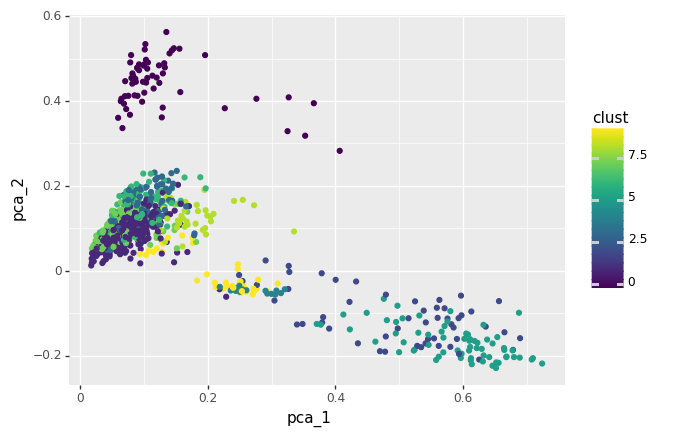

<ggplot: (8793053045569)>

In [87]:
p9.ggplot(X_df, p9.aes(x='pca_1',y='pca_2',color='clust')) + p9.geom_point()